# Active Learning on a 2D toy example

This notebook demonstrates how to apply a variety of acquisition functions for doing active learning on a simple 2D classification problem. Both classic acquisition functions as well as a prediction-oriented one is considered. These are:
- Variation Ratios - VR ($formula$)
- Bayesian Active Learning by Disagreement - BALD ($formula$)
- Expected Predictive Information Gain - EPIG ($formula$)

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from src.visualization.toy_example import plot_data, show_density_grid, show_acquisition_grid
from src.data.toy_example import generate_data
from src.methods.acquisition_functions import Random, VariationRatios, BALD, EPIG

### Data generation

For illustrating a variety of active learning methods a 2D toy example is considered. The specific one at hand is the non-linear classification task associated with `sklearn`'s `make_moons`-dataset. As defined below, the data configuration consists of $N_{initial} = 5$, $N_{test}=100$ and $N_{pool}=500$ data points.

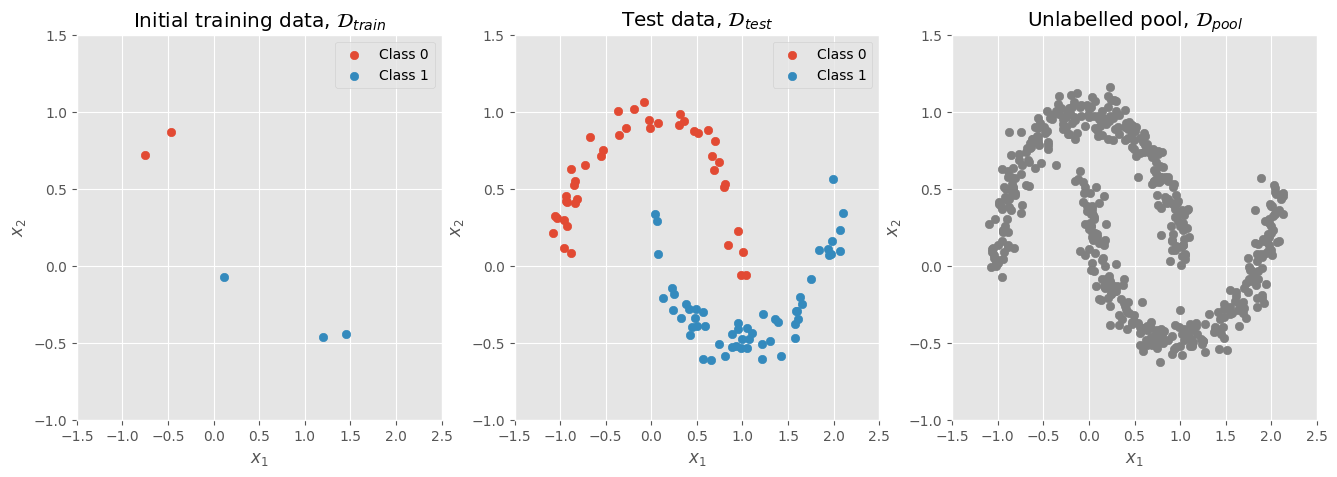

In [2]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 5
N_test      = 100
N_pool      = 500

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_data(N_initial=N_initial, N_test=N_test, N_pool=N_pool)

# Plot the dataset partitions
plot_data(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

### Visualizing model predictions

For optimally querying the pool for new data points, a model outputting proper uncertainty estimates is a strict requirement. For simplicity, we consider a Gaussian Process (GP) classification model and exploit `sklearn` for an easy implementation.   

In [3]:
# Define model
model = GaussianProcessClassifier(1.0 * RBF(1.0))

# Train model
model.fit(Xtrain, ytrain)
# Show performance
print(f"ACCURACY\n  -> train: {model.score(Xtrain, ytrain)}\n  -> test: {model.score(Xtest, ytest)}")

ACCURACY
  -> train: 1.0
  -> test: 0.86


As is validly seen from the above results, the test performance suffers from the small size of the training data. As such, we approach selection of additional data points through active learning. In the following cell, one data point is queried by exploiting the `VariationRatios` acquisition function.

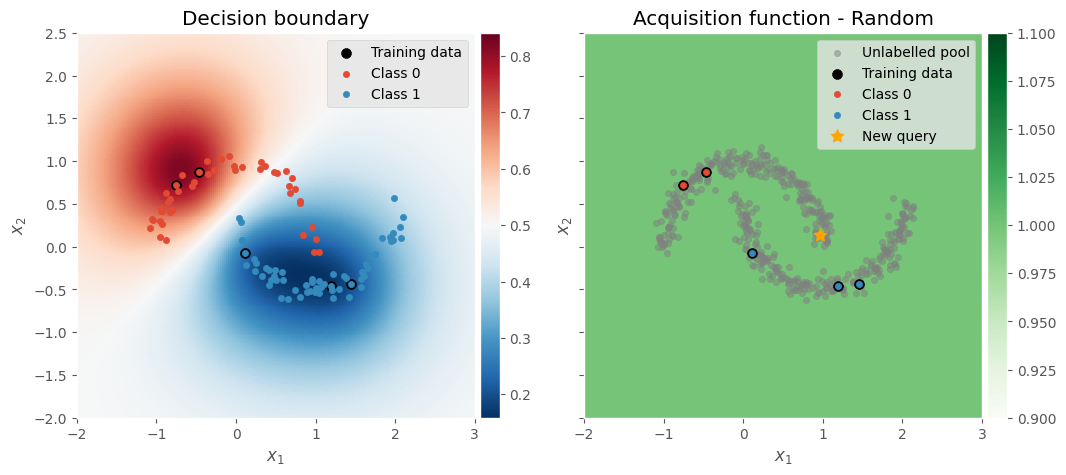

In [4]:
# Define acquisition function
acq_fun = VariationRatios(query_n_points=None)
acq_fun = Random(query_n_points=None)

# Get posterior predictive of data in the pool
pool_probs = model.predict_proba(Xpool)

# Get acquisition function score and the items to query
_, query_idxs = acq_fun(pool_probs)
next_query = Xpool[query_idxs[0]]


### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

# Plot model uncertainty across grid
axs[0] = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, zoom=([-2, 3], [-2, 2.5]), ax=axs[0], fig=fig)
axs[0].legend()

# Plot acquisition function across a grid
axs[1] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, zoom=([-2, 3], [-2, 2.5]), P=200, ax=axs[1], fig=fig)
axs[1].scatter(next_query[0], next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
axs[1].legend()

plt.show()

### Running the active learning loop

In [3]:
import imageio
from PIL import Image

import pickle
from collections import defaultdict

from src.methods.acquisition_functions import AcquisitionFunction

def run_active_learning_loop(
    model,
    acq_fun: AcquisitionFunction,
    Xtrain: np.ndarray, Xtest: np.ndarray, Xpool: np.ndarray, 
    ytrain: np.ndarray, ytest: np.ndarray, ypool: np.ndarray,
    n_iterations: int = 1, 
    save_dir: str = '../reports/figures/2D_toy/example/', 
    save_fig=False, verbose=1, animate=False, fps=10.,
):
    # Create folder for saving results
    os.makedirs(f'{save_dir}/{acq_fun.name}', exist_ok=True)
    os.makedirs(f'{save_dir}/{acq_fun.name}/images', exist_ok=True)
    img_list = []

    # Run active learning loop
    performance = defaultdict(list)
    for i in range(n_iterations):

        # Train model
        model.fit(Xtrain, ytrain)
        
        # Update performance dictionary
        performance['train'].append(model.score(Xtrain, ytrain))
        performance['test'].append(model.score(Xtest, ytest))
        performance['N_points'].append(Xtrain.__len__())

        # Get posterior predictive of data in the pool
        pool_probs = model.predict_proba(Xpool)

        # Get acquisition function score and the items to query
        _, query_idxs               = acq_fun(pool_probs)
        X_next_query, y_next_query  = Xpool[query_idxs[0]], ypool[query_idxs[0]]

        if save_fig:
            ### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
            fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

            # Plot model uncertainty across grid
            axs[0] = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, zoom=([-2, 3], [-2, 2.5]), ax=axs[0], fig=fig)
            axs[0].legend()

            # Plot acquisition function across a grid
            axs[1] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, zoom=([-2, 3], [-2, 2.5]), P=100, ax=axs[1], fig=fig)
            axs[1].scatter(X_next_query[0], X_next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
            axs[1].legend()

            img_list.append(f'{save_dir}/{acq_fun.name}/images/iteration{i}.png')
            plt.savefig(f'{save_dir}/{acq_fun.name}/images/iteration{i}.png')
            plt.close()

        ### UPDATE TRAINING SET AND POOL ACCORDINGLY ###
        Xtrain  = np.vstack([Xtrain, X_next_query])
        ytrain  = np.hstack([ytrain, y_next_query])
        Xpool   = np.delete(Xpool, query_idxs[0], 0)
        ypool   = np.delete(ypool, query_idxs[0], 0)

        if verbose == 1:
            print(
                f"Train acc.: {performance['train'][i]:.2f} |",
                f"Test acc.: {performance['test'][i]:.2f} |",
                f"|ytrain|: {performance['N_points'][i]} points   |",
                f"Remaining pool: {Xpool.__len__()} points   |",
                f"Query: [{X_next_query[0]:.2f}, {X_next_query[1]:.2f}]",
                sep='   ',
            )

    # Fit final model
    model.fit(Xtrain, ytrain)
    # Get performance
    performance['train'].append(model.score(Xtrain, ytrain))
    performance['test'].append(model.score(Xtest, ytest))
    performance['N_points'].append(Xtrain.__len__())

    if verbose == 1:
        print(
            f"Train acc.: {performance['train'][i+1]:.2f}   |",
            f"Test acc.: {performance['test'][i+1]:.2f}   |",
            f"|ytrain|: {performance['N_points'][i+1]} points  |",
            sep='   ',
        )
    
    # Store results
    with open(f'{save_dir}/{acq_fun.name}/performance.pkl', 'wb') as f:
        pickle.dump(performance, f)

    if save_fig and animate:
        # Load and sort images
        images = [Image.open(path) for path in img_list]

        # Set output path for GIF
        output_gif_path = f'{save_dir}/{acq_fun.name}/querying_process.gif'
        # Save GIF
        imageio.mimsave(output_gif_path, images, duration=(1000 * 1/fps))

    return model, performance, Xtrain, ytrain

In [6]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 4
N_test      = 100
N_pool      = 20

# Define acquisition function
acq_fun = Random(query_n_points=None)

# Define model
model = GaussianProcessClassifier(1.0 * RBF(1.0))

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_data(N_initial=N_initial, N_test=N_test, N_pool=N_pool)

# Run active learning loop
model, performance, Xtrain, ytrain = run_active_learning_loop(
    model,
    acq_fun=acq_fun,
    Xtrain=Xtrain, Xtest=Xtest, Xpool=Xpool, 
    ytrain=ytrain, ytest=ytest, ypool=ypool,
    n_iterations=N_pool,
    save_fig=True, 
    animate=True, fps=1,
)

Train acc.: 1.00 |   Test acc.: 0.80 |   |ytrain|: 4 points   |   Remaining pool: 19 points   |   Query: [0.21, 0.98]
Train acc.: 1.00 |   Test acc.: 0.79 |   |ytrain|: 5 points   |   Remaining pool: 18 points   |   Query: [-0.21, 0.97]
Train acc.: 1.00 |   Test acc.: 0.80 |   |ytrain|: 6 points   |   Remaining pool: 17 points   |   Query: [0.76, 0.68]
Train acc.: 1.00 |   Test acc.: 0.81 |   |ytrain|: 7 points   |   Remaining pool: 16 points   |   Query: [0.31, -0.21]
Train acc.: 1.00 |   Test acc.: 0.88 |   |ytrain|: 8 points   |   Remaining pool: 15 points   |   Query: [2.05, 0.53]
Train acc.: 1.00 |   Test acc.: 0.88 |   |ytrain|: 9 points   |   Remaining pool: 14 points   |   Query: [0.76, -0.40]
Train acc.: 1.00 |   Test acc.: 0.88 |   |ytrain|: 10 points   |   Remaining pool: 13 points   |   Query: [0.87, 0.27]
Train acc.: 1.00 |   Test acc.: 0.93 |   |ytrain|: 11 points   |   Remaining pool: 12 points   |   Query: [-0.83, 0.15]
Train acc.: 1.00 |   Test acc.: 0.92 |   |ytrain|:

In [7]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 4
N_test      = 100
N_pool      = 20

# Define acquisition function
acq_fun = VariationRatios(query_n_points=None)

# Define model
model = GaussianProcessClassifier(1.0 * RBF(1.0))

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_data(N_initial=N_initial, N_test=N_test, N_pool=N_pool)

# Run active learning loop
model, performance, Xtrain, ytrain = run_active_learning_loop(
    model,
    acq_fun=acq_fun,
    Xtrain=Xtrain, Xtest=Xtest, Xpool=Xpool, 
    ytrain=ytrain, ytest=ytest, ypool=ypool,
    n_iterations=N_pool,
    save_fig=True, 
    animate=True, fps=1,
)

Train acc.: 1.00 |   Test acc.: 0.80 |   |ytrain|: 4 points   |   Remaining pool: 19 points   |   Query: [0.69, 0.59]
Train acc.: 1.00 |   Test acc.: 0.81 |   |ytrain|: 5 points   |   Remaining pool: 18 points   |   Query: [1.07, 0.37]
Train acc.: 1.00 |   Test acc.: 0.90 |   |ytrain|: 6 points   |   Remaining pool: 17 points   |   Query: [0.31, -0.21]
Train acc.: 1.00 |   Test acc.: 0.96 |   |ytrain|: 7 points   |   Remaining pool: 16 points   |   Query: [-0.03, 0.35]
Train acc.: 1.00 |   Test acc.: 0.96 |   |ytrain|: 8 points   |   Remaining pool: 15 points   |   Query: [0.21, 0.98]
Train acc.: 1.00 |   Test acc.: 1.00 |   |ytrain|: 9 points   |   Remaining pool: 14 points   |   Query: [1.16, 0.10]
Train acc.: 1.00 |   Test acc.: 1.00 |   |ytrain|: 10 points   |   Remaining pool: 13 points   |   Query: [2.05, 0.53]
Train acc.: 1.00 |   Test acc.: 1.00 |   |ytrain|: 11 points   |   Remaining pool: 12 points   |   Query: [-0.83, 0.15]
Train acc.: 1.00 |   Test acc.: 1.00 |   |ytrain|: 